<a href="https://colab.research.google.com/github/vaidhyesh1/parallel-computing/blob/main/Data_Analytics_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analytics for Cybersecurity - Homework 3**
  
####*Vaidhyesh Padma Sundar*
####*231002865*

We import the libraries needed first

In [ ]:
import numpy as np
from datetime import datetime 

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import time

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Mounting Gdrive so that the test and train files are accessible

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Fall_2022/Data_Analytics/HW3

hw3-letters-test-images-idx3-ubyte  hw3-letters-train-images-idx3-ubyte
hw3-letters-test-labels-idx1-ubyte  hw3-letters-train-labels-idx1-ubyte


## Custom Data Loader Class
A custom class for the dataloader is loaded with pytorch and the images file and label file are passed as parameters to the \_\_init__ function. Then the files are parsed to retrieve the image pixel data and the labels. These values are exposed using the \_\_getitem__ method.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class AlphabetDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        with open(images_file,'rb') as f:
            num_images = int.from_bytes(f.read(4), byteorder='big')
            nrows = int.from_bytes(f.read(4), byteorder='big')
            ncols = int.from_bytes(f.read(4), byteorder='big')
            data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
            self.images = data.reshape((num_images, nrows, ncols))

        with open(labels_file,'rb') as f:
            num_labels = int.from_bytes(f.read(4), byteorder='big')
            labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
            self.labels = labels.reshape((num_images,))
            
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]/255
        label = self.labels[idx]-1
        image = torch.from_numpy(image[None, :])
        if self.transform:
            image = self.transform(image)
        return image, label

Using the custom data loader class, I create a training set, validation set and a testing set.  
The training data is split into a train set and a validation set using an 80-20 split

In [ ]:
training_image = '/content/drive/MyDrive/Fall_2022/Data_Analytics/HW3/hw3-letters-train-images-idx3-ubyte'
training_labels = '/content/drive/MyDrive/Fall_2022/Data_Analytics/HW3/hw3-letters-train-labels-idx1-ubyte'

test_image = '/content/drive/MyDrive/Fall_2022/Data_Analytics/HW3/hw3-letters-test-images-idx3-ubyte'
test_labels = '/content/drive/MyDrive/Fall_2022/Data_Analytics/HW3/hw3-letters-test-labels-idx1-ubyte'

train_dataset = AlphabetDataset(training_image, training_labels)

TRAINING_SPLIT = 0.75
VALIDATION_SPLIT = 1 - TRAINING_SPLIT

numTrainSamples = int(len(train_dataset) * TRAINING_SPLIT)
numValSamples = len(train_dataset) - numTrainSamples

(train_dataset, val_dataset) = random_split(train_dataset,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

test_dataset = AlphabetDataset(test_image, test_labels)


Plotting 20 grayscale images from the dataset

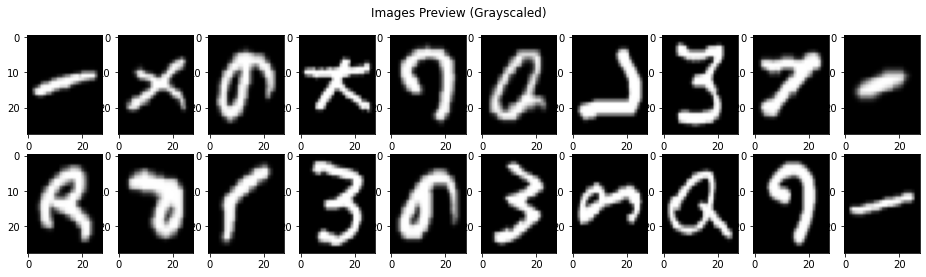

In [ ]:
fig, ax = plt.subplots(2,10) 
fig.set_size_inches(16, 4)

row = 0
for i in range(20):
  img, label = train_dataset[i]
  if i==10:
    row += 1
  ax[row][i%10].imshow(img[0], cmap='gray', aspect='auto')
fig.suptitle('Images Preview (Grayscaled)');

Reusing helper methods taken from https://github.com/erykml/medium_articles/blob/master/Computer%20Vision/lenet5_pytorch.ipynb


In [ ]:
def plot_confusion_matrix(model, data_loader, device):
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        model.eval()
        for X, label in data_loader:

            X = X.to(device)
            label = label.to(device)

            _, y_prob = model(X.float())
            _, predicted_labels = torch.max(y_prob, 1)

            predicted_labels = predicted_labels.cpu().numpy()
            labels = label.cpu().numpy()
            
            y_pred.extend(predicted_labels)
            y_true.extend(labels)

    classes = ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    cf_matrix = np.around(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis], decimals=3)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *26, index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (20,12))
    sn.heatmap(df_cm, annot=True)

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, label in data_loader:

            X = X.to(device)
            label = label.to(device)

            _, y_prob = model(X.float())
            _, predicted_labels = torch.max(y_prob, 1)

            n += label.size(0)
            correct_pred += (predicted_labels == label).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X.float()) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X.float()) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        train_acc = get_accuracy(model, train_loader, device=device)
        valid_acc = get_accuracy(model, valid_loader, device=device)
            
        print(f'{datetime.now().time().replace(microsecond=0)} --- '
              f'Epoch: {epoch}\t'
              f'Train loss: {train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Train accuracy: {100 * train_acc:.2f}\t'
              f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1),
            nn.Tanh(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=3200, out_features=500),
            nn.Tanh(),
            nn.Linear(in_features=500, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
# parameters
LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPOCHS = 15

IMG_SIZE = 28
N_CLASSES = 26

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

02:36:20 --- Epoch: 0	Train loss: 0.6368	Valid loss: 0.4347	Train accuracy: 87.68	Valid accuracy: 86.65
02:36:29 --- Epoch: 1	Train loss: 0.3715	Valid loss: 0.3546	Train accuracy: 90.11	Valid accuracy: 88.72
02:36:38 --- Epoch: 2	Train loss: 0.3163	Valid loss: 0.3311	Train accuracy: 91.03	Valid accuracy: 89.63
02:36:47 --- Epoch: 3	Train loss: 0.2871	Valid loss: 0.3206	Train accuracy: 91.58	Valid accuracy: 89.95
02:36:56 --- Epoch: 4	Train loss: 0.2676	Valid loss: 0.3121	Train accuracy: 91.77	Valid accuracy: 89.90
02:37:05 --- Epoch: 5	Train loss: 0.2555	Valid loss: 0.3030	Train accuracy: 92.46	Valid accuracy: 90.17
02:37:15 --- Epoch: 6	Train loss: 0.2424	Valid loss: 0.2994	Train accuracy: 92.64	Valid accuracy: 90.62
02:37:24 --- Epoch: 7	Train loss: 0.2344	Valid loss: 0.3209	Train accuracy: 92.06	Valid accuracy: 89.82
02:37:33 --- Epoch: 8	Train loss: 0.2232	Valid loss: 0.3026	Train accuracy: 93.03	Valid accuracy: 90.43
02:37:42 --- Epoch: 9	Train loss: 0.2143	Valid loss: 0.3029	Trai

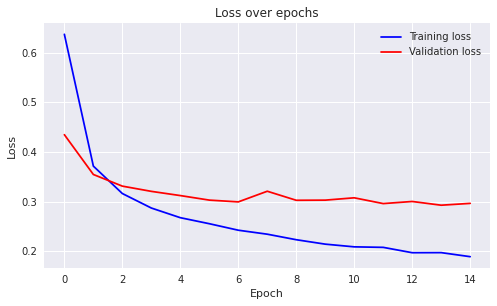

In [ ]:
start = time.time()
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, val_loader, N_EPOCHS, DEVICE)
stop = time.time()
print(f"Training time: {stop - start}s")
# Training time with GPU: 143.411 seconds
# Training time with CPU: 2254.499 seconds

Test accuracy: 90.80



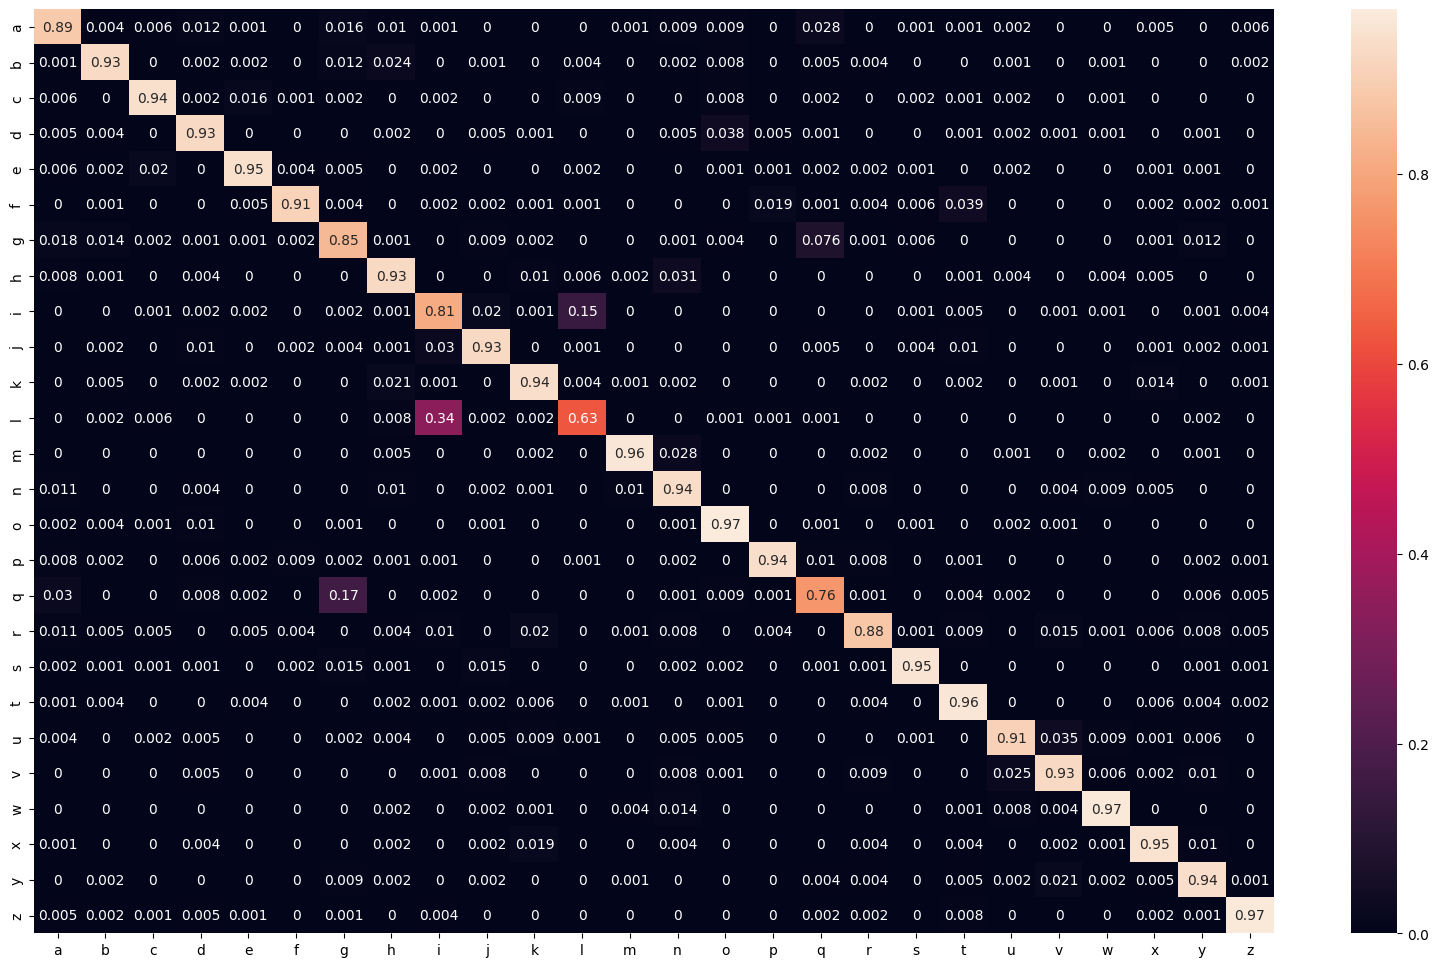

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'Test accuracy: {100 * get_accuracy(model, test_loader, DEVICE).item():.2f}\n')
plot_confusion_matrix(model, test_loader, DEVICE)